# `00` Problem Statement:

The goal is to estimate the direction in which the person is looking.  
This can be done using the orientation of the head.  
The orientation of the head can be defined in terms of pitch, roll, and yaw movements describing the three degrees of freedom of a human head.  

<center><img src="https://www.researchgate.net/profile/Tsang-Ing-Ren/publication/279291928/figure/fig1/AS:292533185462272@1446756754388/Orientation-of-the-head-in-terms-of-pitch-roll-and-yaw-movements-describing-the-three.png" alt="Head Pose angles"></center>

# `01` Loading Required Libraries:

In [1]:
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import glob
import scipy.io

# `02` Exploring ALFW2000 Dataset:

Num of images:  2000
Image shape:  (450, 450, 3)


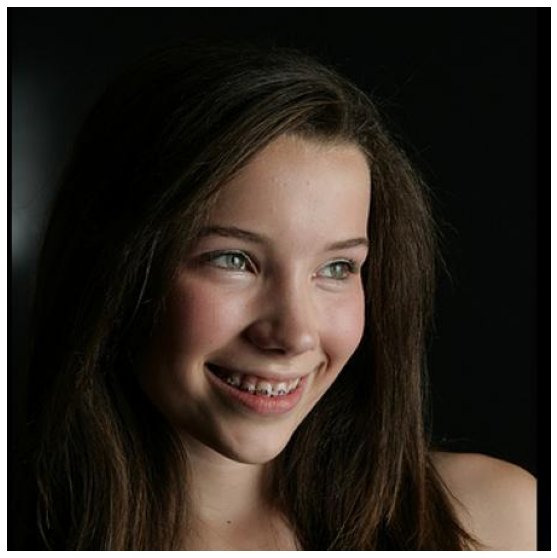

In [130]:
DEMO_IMG_NUMBER = 805
images_paths = glob.glob('./AFLW2000/*.jpg')
print('Num of images: ', len(images_paths))
img = cv2.imread(images_paths[DEMO_IMG_NUMBER])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: ', img.shape)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(img);

In [131]:
img_info_paths = glob.glob('./AFLW2000/*.mat')
mat = scipy.io.loadmat(img_info_paths[DEMO_IMG_NUMBER])
mat['Pose_Para'][0][:3]                 #Extracting pitch, yaw, and roll

array([-0.31531143, -0.33785677,  0.1856054 ], dtype=float32)

We can use mediapipe's mesh grid to find the landmarks of the face, which can be used as input to our model to estimate the rotation angles.  
and we can use landmark $1$ that defines the nose, which can be used as the origin point in our system and we will translate our axes to that new origin.

nose position:  (244.2385733127594, 283.98174941539764)


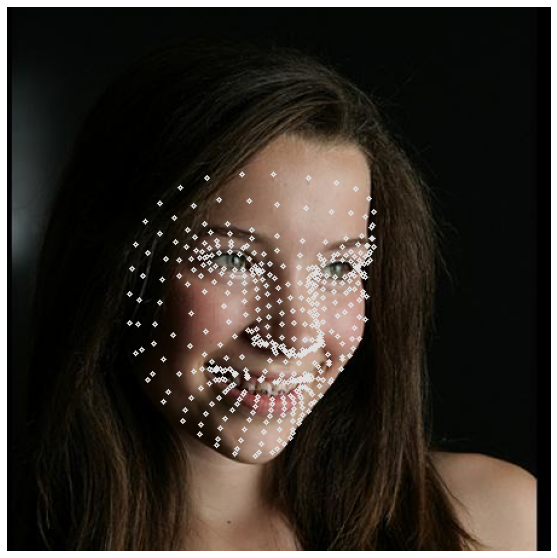

In [132]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
drawing_specs = mp.solutions.drawing_utils.DrawingSpec(thickness=1, circle_radius=1)
result = face_mesh.process(img)

img_h, img_w, img_c = img.shape
annot_img = img.copy()

if result.multi_face_landmarks != None:
    for face_landmarks in result.multi_face_landmarks:        
        mp.solutions.drawing_utils.draw_landmarks(image=annot_img, landmark_list=face_landmarks, landmark_drawing_spec=drawing_specs)
        for idx, lm in enumerate(result.multi_face_landmarks[0].landmark):
            if idx == 1:
                nose_x = lm.x * img_w
                nose_y = lm.y * img_h

print('nose position: ', (nose_x, nose_y))
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(annot_img);

We can look at the axes rotation in 2 similar ways:  
1- Keeping the original axes as they are and rotating the object around them using the pitch, roll, and yaw  
2- Rotating the axes themselves, while keeping the object in a fixed position with respect to the axes, this is called Euler rotation.  

Euler rotation can be defined in 3 successive steps:  
1- Rotation around the $x$ axis with angle $\gamma$ -> same as pitch  
2- Rotation around the new $y$ axis with angle $\beta$ -> same as yaw  
3- Rotation around the new $z$ axis with angle $\alpha$ -> same as roll  

So we first define our original axes, which is the identity matrix, we then rotate them using the euler rotation, then we project the new axes point to the 2D space of the image using the simplest form of projection (orthogonal projection which works by just dropping the z-axis), finally we translate the new axes to the nose position. 

In [133]:
def draw_axes(img, pitch, yaw, roll, tx, ty, size=50):
    yaw = -yaw
    rotation_matrix = cv2.Rodrigues(np.array([pitch, yaw, roll]))[0].astype(np.float64)
    axes_points = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]
    ], dtype=np.float64)
    axes_points = rotation_matrix @ axes_points
    axes_points = (axes_points[:2, :] * size).astype(int)
    axes_points[0, :] = axes_points[0, :] + tx
    axes_points[1, :] = axes_points[1, :] + ty
    
    new_img = img.copy()
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 0].ravel()), (255, 0, 0), 3)
    cv2.putText(new_img, 'x', tuple(axes_points[:, 0].ravel()), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 0), 1)
    
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 1].ravel()), (0, 255, 0), 3)
    cv2.putText(new_img, 'y', tuple(axes_points[:, 1].ravel()), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 255, 0), 1)
    
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 2].ravel()), (0, 0, 255), 3)
    cv2.putText(new_img, 'z', tuple(axes_points[:, 2].ravel()), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 0, 255), 1)

    return new_img

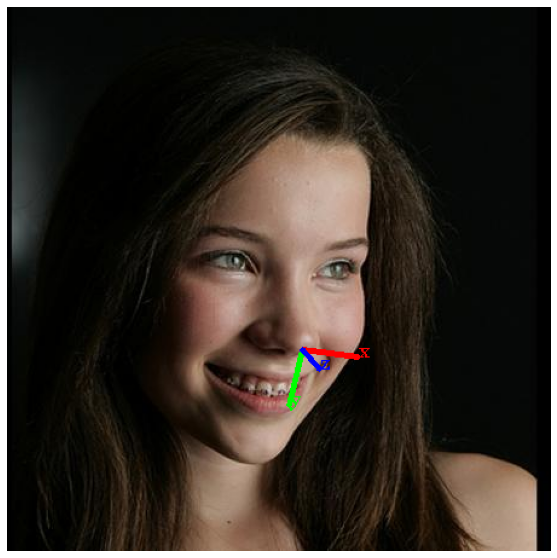

In [134]:
pitch, yaw, roll = mat['Pose_Para'][0][:3]
new_img = draw_axes(img, pitch, yaw, roll, nose_x, nose_y)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(new_img);

# `03` Feature Extraction:

As most of the points in the face mesh are close to each other and don't offer new information.  
I will use some of the main points of the face mesh grid as the features, and use them to estimate the value of the rotation angles: pitch, yaw, and roll.

In [135]:
def extract_features(img, face_mesh, mat=None):
    NOSE = 1
    FOREHEAD = 10
    LEFT_EYE = 33
    MOUTH_LEFT = 61
    CHIN = 199
    RIGHT_EYE = 263
    MOUTH_RIGHT = 291


    result = face_mesh.process(img)
    face_features = []

    if result.multi_face_landmarks != None:
        for face_landmarks in result.multi_face_landmarks:
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx in [FOREHEAD, NOSE, MOUTH_LEFT, MOUTH_RIGHT, CHIN, LEFT_EYE, RIGHT_EYE]:
                    face_features.append(lm.x)
                    face_features.append(lm.y)
    else:
        face_features.extend([None] * 14)
    
    if mat:
        pose_angles = mat['Pose_Para'][0][:3]
        face_features.extend(pose_angles)
        
    return face_features

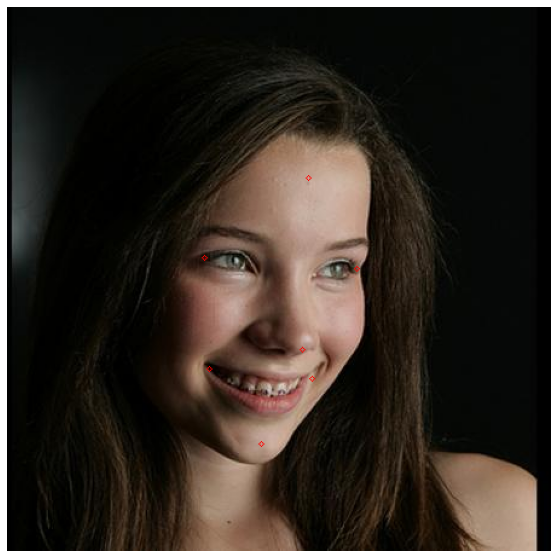

In [136]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
s = extract_features(img, face_mesh)
annot_img = img.copy()

for i in range(len(s)//2):
        cv2.circle(annot_img, center=[int(s[i*2]*img_w), int(s[i*2+1]*img_h)], radius=2, color=(255, 0, 0))
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(annot_img);


# `04` Saving Data to csv File:

In [19]:
cols = []
for pos in ['nose_', 'forehead_', 'left_eye_', 'mouth_left_', 'chin_', 'right_eye_', 'mouth_right_']:
    for dim in ('x', 'y'):
        cols.append(pos+dim)
cols.extend(['pitch', 'yaw', 'roll'])

In [20]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
poses = []

for img_idx, img_path in enumerate(images_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mat = scipy.io.loadmat(img_info_paths[img_idx])
    face_features = extract_features(img, face_mesh, mat)
    poses.append(face_features)
    if img_idx % 100 == 0:
        print('Extracted images: ', img_idx)

poses_df = pd.DataFrame(poses, columns=cols)

Extracted images:  0
Extracted images:  100
Extracted images:  200
Extracted images:  300
Extracted images:  400
Extracted images:  500
Extracted images:  600
Extracted images:  700
Extracted images:  800
Extracted images:  900
Extracted images:  1000
Extracted images:  1100
Extracted images:  1200
Extracted images:  1300
Extracted images:  1400
Extracted images:  1500
Extracted images:  1600
Extracted images:  1700
Extracted images:  1800
Extracted images:  1900


In [24]:
poses_df

,nose_x,nose_y,forehead_x,forehead_y,left_eye_x,left_eye_y,mouth_left_x,mouth_left_y,chin_x,chin_y,right_eye_x,right_eye_y,mouth_right_x,mouth_right_y,pitch,yaw,roll
0,0.489194,0.639722,0.521101,0.295806,0.354743,0.441597,0.403753,0.680927,0.481321,0.807920,0.669544,0.473942,0.574203,0.702994,-0.399231,0.018227,0.085676
1,0.401499,0.604184,0.475316,0.344523,0.408574,0.481754,0.421570,0.668330,0.447475,0.764491,0.605816,0.506940,0.523344,0.691370,0.470065,1.189533,0.300959
2,0.445534,0.621876,0.443547,0.373616,0.424176,0.508653,0.480120,0.683903,0.528819,0.769280,0.586251,0.500861,0.582848,0.679839,-0.184650,0.881137,-0.236852
3,0.467992,0.648420,0.407912,0.370758,0.354222,0.524016,0.463581,0.699305,0.551854,0.780015,0.605186,0.467229,0.604576,0.666296,-0.175379,0.299208,-0.373374
4,0.372060,0.621196,0.395060,0.392921,0.397376,0.513964,0.433618,0.697691,0.467873,0.773994,0.525802,0.498256,0.508779,0.698543,-0.882169,1.198004,-1.033374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.486602,0.624109,0.522991,0.301004,0.354324,0.441646,0.412282,0.681156,0.483026,0.786989,0.680817,0.491351,0.567541,0.702234,-0.197102,-0.070430,0.105118
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.232617,-1.418751,0.175960
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.447955,1.431267,-1.509418
1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.420465,-1.191176,0.451515


In [89]:
poses_df.to_csv('./poses.csv', index=False)